In [2]:
from dotenv import load_dotenv
load_dotenv()


True

In [1]:
from langchain_teddynote import logging

logging.langsmith("Sql_Agent")


LangSmith 추적을 시작합니다.
[프로젝트명]
Sql_Agent


In [3]:
schema = """
| No | 컬럼(영문명)  | 항목명                | 항목설명                                            |
|----|---------------|-----------------------|-----------------------------------------------------|
| 1  | STRD_YYMM    | 기준년월              | 매출이 발생한 월(YYYYMM)                            |
| 2  | STRD_DATE    | 기준일자              | 매출이 발생한 일자(YYYYMMDD)                         |
| 3  | WK_CD        | 평일/주말 코드        | 1: 평일, 2: 주말                                    |
| 4  | TIMC_CD      | 시간대 코드           | 1: 아침(05-10), 2: 점심(11-16), 3: 저녁(17-21), 4: 밤(22-04) |
| 5  | MER_SIDO_CD  | (가맹점)광역시도 코드  | 가맹점소재지(광역시도)                               |
| 6  | MER_CCG_CD   | (가맹점)시군구 코드    | 가맹점소재지(시군구)                                 |
| 7  | MER_ADNG_CD  | (가맹점)행정동 코드    | 가맹점소재지(행정동) - 뒷자리 00을 제외한 8자리 코드  |
| 8  | BUZ_LCLS_NM  | 업종명(대)            | AI 업종명 대분류                                    |
| 9  | BUZ_MCLS_NM  | 업종명(중)            | AI 업종명 중분류                                    |
| 10 | BUZ_SCLS_NM  | 업종명(소)            | AI 업종명 소분류                                    |
| 11 | CST_SIDO_CD  | (고객 자택)광역시도 코드 | 고객자택주소지(광역시도)                             |
| 12 | CST_CCG_CD   | (고객 자택)시군구 코드  | 고객자택주소지(시군구)                               |
| 13 | CST_ADNG_CD  | (고객 자택)행정동 코드   | 고객자택주소지(행정동) - 뒷자리 00을 제외한 8자리 코드  |
| 14 | SEX_CD       | 성별 코드             | 1: 남, 2: 여                                        |
| 15 | AGE_CD       | 연령대 코드           | 20: 20대이하, 30:30대, 40: 40대, 50: 50대, 60: 60대이상 |
| 16 | HOSH_TYP_CD  | 가구유형코드           | 1: 1인가구, 2: 신혼영유아가구, 3: 초중고자녀가구, 4: 성인자녀가구, 5: 노인가구, 9: 알수없음 |
| 17 | INCM_NR_CD   | 소득분위코드           | 1: 1분위수, 2: 2분위수, 3: 3분위수, 4: 4분위수, 5: 5분위수, 9: 알수없음 |
| 18 | AMT          | 매출금액              | 카드매출금액 합계(백원 단위 라운딩)                  |
| 19 | CNT          | 매출건수              | 카드매출건수 합계                                   |

"""

In [4]:
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq

llm = ChatGroq(
    model_name="qwen-2.5-32b",
    # model_name="deepseek-r1-distill-llama-70b"
)

In [5]:
from langchain.chains import create_sql_query_chain
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스에 연결합니다.
db = SQLDatabase.from_uri("sqlite:///data.db")

# 데이터베이스의을 출력합니다.
print(db.dialect)

# 사용 가능한 테이블 이름들을 출력합니다.
print(db.get_usable_table_names())

sqlite
['sales']


In [6]:
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field

prompt = PromptTemplate(
    template=    """Given an input question, first create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer. Unless the user specifies in his question a specific number of examples he wishes to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.
        Use the following format:
        Please response Just SQL Query, not any other text.
        
        Only use the following tables:
        {table_info}

        Question: {input}""",
    input_variables=["input", "table_info", "dialect"], 
    partial_variables={"dialect": db.dialect}
)

sql_generate_chain = create_sql_query_chain(llm, db, prompt)

generated_sql_query = sql_generate_chain.invoke({
    "question": "성별에 다른 매출금액 .",
})
print(generated_sql_query)


SELECT SEX_CD, SUM(AMT) AS TOTAL_AMT FROM sales GROUP BY SEX_CD LIMIT 5;


In [7]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

execute_query = QuerySQLDatabaseTool(
    db=db, 
    return_format="json"
)

execute_query.invoke({"query": generated_sql_query})


'[(1, 2076671400), (2, 3670659400)]'

In [8]:
sql_chain = create_sql_query_chain(llm, db, prompt) | execute_query 

In [9]:
sql_chain.invoke({"question": "성별에 따른 매출금액을 추출해주세요."})


'[(1, 2076671400), (2, 3670659400)]'

In [10]:
from langchain_core.output_parsers import StrOutputParser
answer_prompt = PromptTemplate.from_template(
    """
    Given the results of the SQL query, return the answer to the question.

    Question: {question}
    SQLQuery: {query}
    SQLResult: {result}
    Answer:
    """
)
answer_chain = answer_prompt | llm | StrOutputParser()
answer_chain.invoke({"question": "성별에 따른 매출금액을 추출해주세요.", "query": generated_sql_query, "result": execute_query.invoke({"query": generated_sql_query})})


'성별에 따른 매출금액은 다음과 같습니다:\n\n- 남성 (코드 1): 2,076,671,400원\n- 여성 (코드 2): 3,670,659,400원\n\n이 결과는 각 성별에 대한 총 매출금액을 나타냅니다.'

In [11]:
purpose = "2023년 봄(3,4월) 축제가 지역별로 매출에 미치는 영향 도출"  

In [13]:
from pydantic import BaseModel, Field
from typing import List
from langchain_core.output_parsers import JsonOutputParser


class DataAnalysisStep(BaseModel):
    step: str = Field(description="데이터 분석 단계")
    description: str = Field(description="데이터 분석 단계 설명")

class DataAnalysisPlan(BaseModel):
    analysis_plan: List[DataAnalysisStep] = Field(description="데이터 분석 단계 리스트")

parser = JsonOutputParser(pydantic_object=DataAnalysisPlan)
format_instructions = parser.get_format_instructions()

data_report_prompt = PromptTemplate(
    template="""
        You are a data analyst.
        주어진 데이터분석 목적과 스키마를 가지고 데이터 분석 계획을 세워주세요.
        이번 분석 계획은 "데이터 탐색 및 분석" 에 초점을 맞추어 진행할 예정입니다.
        데이터 분석 시, 독립변수의 복합적인 관계에서 인사이트를 도출하는 것을 목표로 합니다.
        최소 5개 이상의 단계를 세워주세요.(각 단계는 SQL 을 작성하여 진행할 예정입니다)

        Data Analysis Purpose: {purpose}
        Schema: {schema}
        Answer:

        Please response in Json format.
        {format_instructions}
    """ ,
    input_variables=["purpose", "schema"],
    partial_variables={"format_instructions": format_instructions}
)

data_analysis_plan_chain = data_report_prompt | llm | parser

result = data_analysis_plan_chain.invoke({"purpose": purpose, "schema": schema})



In [14]:
result['analysis_plan']

[{'step': '단계 1: 데이터 준비 및 초기 탐색',
  'description': '2023년 3월과 4월의 데이터만 필터링하여 분석에 사용할 데이터셋을 준비합니다. 이후, 데이터셋의 기본적인 통계 값을 확인하고 결측치나 이상치를 탐색합니다.'},
 {'step': '단계 2: 축제 기간 동안의 매출 분석',
  'description': '2023년 3월과 4월에 개최된 축제 기간 동안의 매출을 분석하기 위해, 해당 기간 동안의 매출을 통계적으로 요약하고, 특정 축제 기간과 매출의 상관성을 탐색합니다.'},
 {'step': '단계 3: 지역별 매출 분석',
  'description': "데이터를 'MER_SIDO_CD' 컬럼으로 그룹화하여 지역별로 매출을 분석합니다. 각 지역의 평균 매출, 매출의 시계열 변화 등을 분석합니다."},
 {'step': '단계 4: 업종별 매출 분석',
  'description': '업종별(대분류, 중분류, 소분류) 매출을 분석하여 축제 기간 동안 특정 업종에서 어떤 변화가 있었는지 탐색합니다.'},
 {'step': '단계 5: 고객 세그먼트 기반의 매출 분석',
  'description': '성별, 연령대, 가구유형, 소득분위 등을 기준으로 고객 세그먼트를 나누고, 각 세그먼트별로 매출 변화를 분석합니다. 이는 고객의 민감도를 이해하고, 특정 세그먼트가 축제 기간 동안 어떻게 반응하는지 살펴볼 수 있습니다.'}]

In [15]:
analysis_result = []

for step in result['analysis_plan']:
    print(step['step'])
    print(step['description'])

    generated_sql_query = sql_generate_chain.invoke({"question": step['description']})
    sql_result = execute_query.invoke({"query": generated_sql_query})

    # answer_chain.invoke({"question": "성별에 따른 매출금액을 추출해주세요.", "query": generated_sql_query, "result": execute_query.invoke({"query": generated_sql_query})})
    answer = answer_chain.invoke({"question": step['description'], "query": generated_sql_query, "result": sql_result})
    print(answer)

    analysis_result.append({
        "step": step['step'],
        "description": step['description'],
        "sql_query": generated_sql_query,
        "result": sql_result,
        "answer": answer
    })


단계 1: 데이터 준비 및 초기 탐색
2023년 3월과 4월의 데이터만 필터링하여 분석에 사용할 데이터셋을 준비합니다. 이후, 데이터셋의 기본적인 통계 값을 확인하고 결측치나 이상치를 탐색합니다.
2023년 3월과 4월의 데이터에 대해 분석한 결과를 보자면:

- 2023년 3월
    - 총 레코드 수: 10,000개
    - 총 거래 금액: 1,074,548,000 단위
    - 총 거래 횟수: 28,398 회

- 2023년 4월
    - 총 레코드 수: 10,000개
    - 총 거래 금액: 1,160,029,200 단위
    - 총 거래 횟수: 25,070 회

이 결과는 각각의 월에 대해 총 레코드 수, 거래 금액, 거래 횟수를 제공하지만, 결측치나 이상치에 대한 정보는 제공하지 않습니다. 결측치나 이상치를 확인하기 위해서는 추가적인 분석이 필요할 것으로 보입니다.
단계 2: 축제 기간 동안의 매출 분석
2023년 3월과 4월에 개최된 축제 기간 동안의 매출을 분석하기 위해, 해당 기간 동안의 매출을 통계적으로 요약하고, 특정 축제 기간과 매출의 상관성을 탐색합니다.
2023년 3월과 4월에 개최된 축제 기간 동안의 매출을 분석한 결과는 다음과 같습니다:

- 2023년 3월:
  - 총 매출: 1,074,548,000원
  - 거래 건수: 10,000건

- 2023년 4월:
  - 총 매출: 1,160,029,200원
  - 거래 건수: 10,000건

이 결과로 볼 때, 3월과 4월 동안 총 거래 건수는 동일하게 10,000건이 발생하였지만, 4월의 총 매출은 3월보다 약 85,481,200원 증가하였습니다. 이러한 증가는 해당 기간 동안 개최된 축제의 영향을 반영할 수 있으며, 추가적인 분석을 통해 축제와 매출 상승 간의 상관성을 더욱 정밀하게 탐색할 수 있을 것입니다.
단계 3: 지역별 매출 분석
데이터를 'MER_SIDO_CD' 컬럼으로 그룹화하여 지역별로 매출을 분석합니다. 각 지역의 평균 매출, 매출의 시계열 변화 등을 분석합

In [16]:
from langchain_core.prompts import PromptTemplate

data_report_final_prompt = PromptTemplate.from_template(
    """
    You are a data analyst.
    데이터 분석 목적과 분석된 결과를 가지고 데이터 분석 보고서를 작성해주세요.
    
    ** 주의사항 **
    1. 작성 시 컬럼영문명과 코드값을 그대로 사용하는 것은 금지하십시오. 
    2. 스키마를 보고 컬럼명과 코드값을 매핑하여 작성하세요
    3. 분석 결과는 무조건 한글로 작성해주세요.

    데이터 분석 목적: {purpose}
    데이터 분석 계획: {analysis_plan}
    데이터 분석 결과: {result}
    Schema: {schema}

    Answer : 
    """
)

data_report_final_chain = data_report_final_prompt | llm | StrOutputParser()

data_report_result = data_report_final_chain.invoke({"purpose": purpose, "analysis_plan": analysis_result, "result": analysis_result, "schema": schema}) 




In [127]:
print(data_report_result)

### 데이터 분석 보고서

#### 1. 분석 목적
2023년 봄(3, 4월) 축제가 지역별로 매출에 미치는 영향을 도출하기 위한 분석입니다.

#### 2. 분석 계획
1. **데이터 검사 및 정제**
   - 2023년 3월과 4월의 데이터를 필터링하여 결측치와 중복값을 처리합니다.
   - SQL 쿼리를 통해 이 기간 내의 데이터를 추출합니다.

2. **지역별 매출 집계**
   - **MER_SIDO_CD**와 **STRD_YYMM**을 기준으로 지역별, 월별로 총 매출금액과 매출건수를 집계합니다.

3. **시간대별 매출 분석**
   - **TIMC_CD**를 사용하여 시간대별 매출금액과 매출건수를 집계하고, 축제 기간 동안의 시간대별 구매 패턴을 파악합니다.

4. **연령대와 성별별 매출 분석**
   - **AGE_CD**와 **SEX_CD**를 기준으로 연령대와 성별별 매출금액과 매출건수를 집계합니다.

5. **가구유형과 소득분위별 매출 분석**
   - **HOSH_TYP_CD**와 **INCM_NR_CD**를 사용하여 가구유형과 소득분위별 매출금액과 매출건수를 집계합니다.

#### 3. 분석 결과
1. **데이터 검사 및 정제**
   - 2023년 3월과 4월의 데이터를 확인한 결과, 일부 결측치와 중복값이 처리되었습니다. 데이터는 정상적으로 정제되었습니다.

2. **지역별 매출 집계**
   - 경기도에서 가장 높은 매출을 기록했습니다. 특히 2023년 3월과 4월에 매출이 크게 발생했습니다.
   - 2023년 3월: 258,203,600원, 매출건수 6,936건
   - 2023년 4월: 270,885,000원, 매출건수 6,054건

3. **시간대별 매출 분석**
   - 2023년 1월 10일부터 1월 15일까지의 시간대별 매출 분석 결과, 시간대 2(점심)에서 가장 높은 매출을 기록했습니다.
   - 시간대 2: 총 매출금액 974,177,800원, 매출건수 19,776건
   - 시간대 1(아침)은 가장 낮은 매출

In [17]:
analysis_result

[{'step': '단계 1: 데이터 준비 및 초기 탐색',
  'description': '2023년 3월과 4월의 데이터만 필터링하여 분석에 사용할 데이터셋을 준비합니다. 이후, 데이터셋의 기본적인 통계 값을 확인하고 결측치나 이상치를 탐색합니다.',
  'sql_query': 'SELECT STRD_YYMM, COUNT(*) AS record_count, SUM(AMT) AS total_amount, SUM(CNT) AS total_count\nFROM sales\nWHERE STRD_YYMM BETWEEN 202303 AND 202304\nGROUP BY STRD_YYMM\nLIMIT 5;',
  'result': '[(202303, 10000, 1074548000, 28398), (202304, 10000, 1160029200, 25070)]',
  'answer': '2023년 3월과 4월의 데이터에 대해 분석한 결과를 보자면:\n\n- 2023년 3월\n    - 총 레코드 수: 10,000개\n    - 총 거래 금액: 1,074,548,000 단위\n    - 총 거래 횟수: 28,398 회\n\n- 2023년 4월\n    - 총 레코드 수: 10,000개\n    - 총 거래 금액: 1,160,029,200 단위\n    - 총 거래 횟수: 25,070 회\n\n이 결과는 각각의 월에 대해 총 레코드 수, 거래 금액, 거래 횟수를 제공하지만, 결측치나 이상치에 대한 정보는 제공하지 않습니다. 결측치나 이상치를 확인하기 위해서는 추가적인 분석이 필요할 것으로 보입니다.'},
 {'step': '단계 2: 축제 기간 동안의 매출 분석',
  'description': '2023년 3월과 4월에 개최된 축제 기간 동안의 매출을 분석하기 위해, 해당 기간 동안의 매출을 통계적으로 요약하고, 특정 축제 기간과 매출의 상관성을 탐색합니다.',
  'sql_query': 'SELECT STRD_YYMM, SUM(AMT) AS TOTAL_AMT, COUN

In [37]:


class ReportChartItem(BaseModel):
    chart_name: str = Field(description="차트 이름")
    chart_generate_prompt: str = Field(description="차트 생성 프롬프트")

class ReportChart(BaseModel):
    charts : List[ReportChartItem] = Field(description="차트 리스트")

parser = JsonOutputParser(pydantic_object=ReportChart)
format_instructions = parser.get_format_instructions()


report_chart_generate_prompt = PromptTemplate(
    template="""
    You are a data analyst.
    주어진 데이터 분석 결과를 가지고 차트를 작성해주세요.
    최종 결과보고서 내용을 뒷받침하는 근거자료가 될 수 있도록 차트를 작성해주세요.

    ** 요구사항 **
    1. 차트 생성 프롬프트에 강조해야 하는 부분을 기재해주세요.
    (예 : 명확하게 비교가 필요한 경우, 특정 조건을 만족하는 경우 등)
    2. 명확하게 비교가 가능한 경우, 데이터를 비교할 수 있는 차트를 그려주세요.
    (예 : 축제기간과 이외기간의 매출금액 비교, 소득분위별 매출금액 비교 등)
    (예 : 매출금액 상위 5개 업종의 일별 매출금액 비교(꺾은선 그래프))
    3. 금액 데이터의 경우, 천원 단위로 라운딩 하여 차트에 표시해주세요.


    ** 차트 예시 **
    - 막대그래프(Bar Chart): 업종별 소비 비중, 연령대별 소비 분포, 성별 소비 비중 비교.
    - 라인차트(Line Chart): 코로나 전후 소비 변화 추이, 분기별 소비 트렌드.
    - 파이차트(Pie Chart): 방문객의 업종별 소비 비중, 개인 vs 법인 소비 비율.
    - 히트맵(Heatmap): 지역별 소비 규모 및 매출 증가율(특히 송파 및 명동 상권 분석).
    - 상권 지도(Geo Map): 주요 소비 지역(강남, 송파, 킨텍스 등)에서 소비 중심 이동 분석.
    - 산점도(Scatter Plot): 고객 세그먼트별 소비 패턴 비교.
    - 워드클라우드(Word Cloud): SNS 데이터 기반 소비 트렌드 시각화(예: "홈카페", "홈쿡" 등 키워드 분석).

    ---
    데이터 분석 목적: {purpose}
    최종 결과 보고서 : {data_report_result}
    Schema: {schema}

    Answer : 


    ---
    Please response in Json format.
    {format_instructions}
    """, 
    input_variables=["purpose", "data_report_result", "schema"],
    partial_variables={"format_instructions": format_instructions}
)

report_chart_generate_chain = report_chart_generate_prompt | llm | parser

report_chart_result = report_chart_generate_chain.invoke({"purpose": purpose, "data_report_result": data_report_result, "schema": schema})




In [38]:
report_chart_result

{'charts': [{'chart_name': 'MonthRevenueComparison',
   'chart_generate_prompt': '3월과 4월의 총 거래 금액을 막대그래프로 비교하여, 축제가 매출에 미친 영향을 분석합니다. 3월의 거래 금액을 천원 단위로 라운딩하여 1,075,000,000원, 4월의 거래 금액을 1,160,000,000원으로 표시합니다.'},
  {'chart_name': 'Top5RegionsRevenue',
   'chart_generate_prompt': '전라남도, 제주특별자치도, 경상남도, 광주광역시, 경상북도의 3월과 4월 평균 매출을 막대그래프로 표시하여, 축제가 매출에 미치는 지역별 효과를 분석합니다. 각 지역의 매출을 천원 단위로 라운딩하여 표시합니다.'},
  {'chart_name': 'Top5RetailersRevenue',
   'chart_generate_prompt': '주유소, 슈퍼마켓, 종합병원, 기타 온라인 쇼핑몰, 치킨 업종의 3월과 4월 매출을 막대그래프로 비교하여, 축제 기간 동안 업종별 매출 변화를 분석합니다. 각 업종의 매출을 천원 단위로 라운딩하여 표시합니다.'},
  {'chart_name': 'GenderAgeRevenueHeatmap',
   'chart_generate_prompt': '성별 및 연령대를 기준으로 3월과 4월의 총 거래 금액을 히트맵으로 표시하여, 매출 변화를 시각화합니다. 매출을 천원 단위로 라운딩하여 표시합니다.'},
  {'chart_name': 'IncomeSegmentRevenue',
   'chart_generate_prompt': '소득 분위별 총 거래 금액을 막대그래프로 표시하여, 20대 남성의 단일 가구 세그먼트에서 소득 분위가 증가함에 따라 매출도 증가하는 경향을 분석합니다. 매출을 천원 단위로 라운딩하여 표시합니다.'}]}

In [39]:



chart_code_generate_prompt = PromptTemplate(
    template="""
    You are a data analyst.
    주어진 차트 생성 프롬프트를 가지고 차트 코드를 작성해주세요.

    ** 주의사항 **
    1. python 코드만 작성해주세요. (주석, 설명 등은 포함하지 마세요.)
    2. 차트 생성에 필요한 라이브러리들에 대한 import 를 포함해주세요.
    3. 비교가 필요한 경우 명확히 구분 가능한 색상을 사용하십시오.
    4. pyplot과 seaborn 라이브러리를 사용하여 차트를 생성하십시오.
    5. 금액 데이터의 경우, 천원 단위로 라운딩 하여 차트에 표시해주세요.
    
    Be sure to use the following font code in your code when generating charts.

    ##### 폰트 설정 #####
    import platform

    # OS 판단
    current_os = platform.system()

    if current_os == "Windows":
        # Windows 환경 폰트 설정
        font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
        fontprop = fm.FontProperties(fname=font_path, size=12)
        plt.rc("font", family=fontprop.get_name())
    elif current_os == "Darwin":  # macOS
        # Mac 환경 폰트 설정
        plt.rcParams["font.family"] = "AppleGothic"
    else:  # Linux 등 기타 OS
        # 기본 한글 폰트 설정 시도
        try:
            plt.rcParams["font.family"] = "NanumGothic"
        except:
            print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")
    
    Chart Generate Prompt: {chart_generate_prompt}
    Chart Name: {chart_name}
    sql : {sql}
    data : {data}

    Answer : 
    """
)
chart_code_generate_chain = chart_code_generate_prompt | llm | StrOutputParser()



<string>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



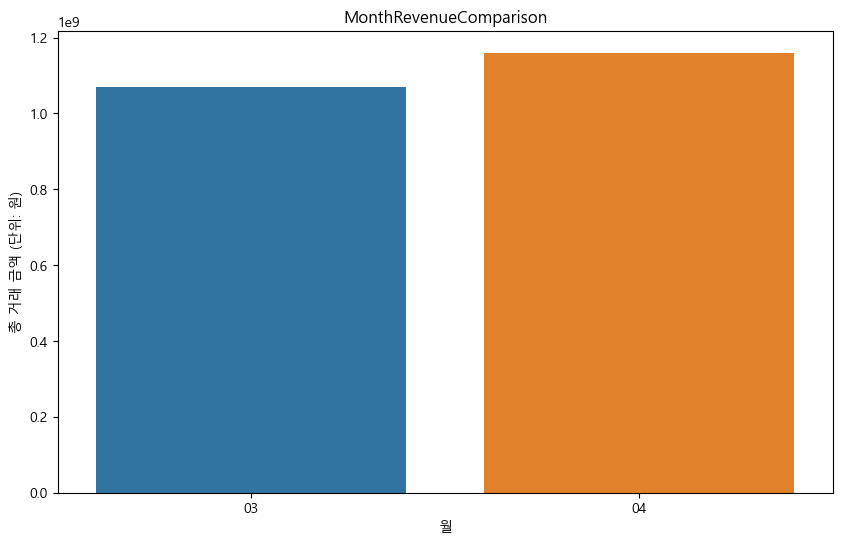

<string>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



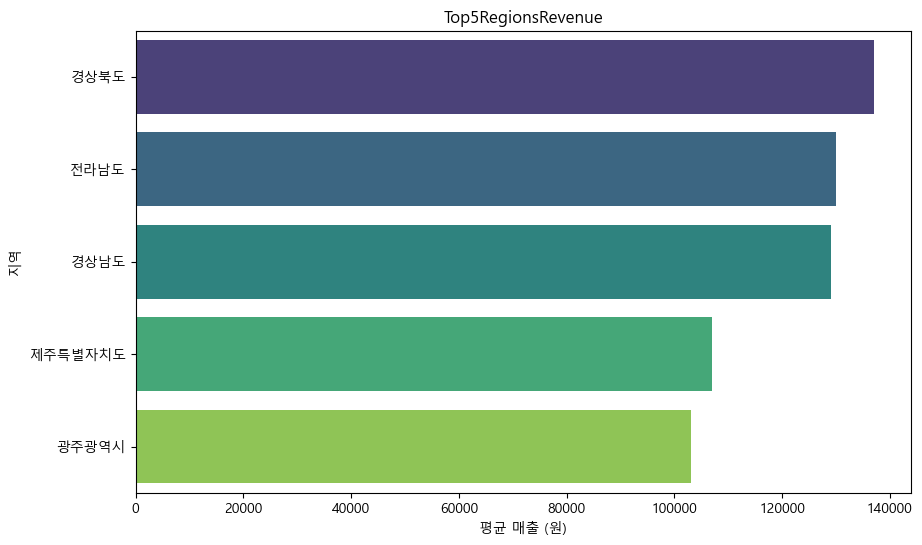

<string>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



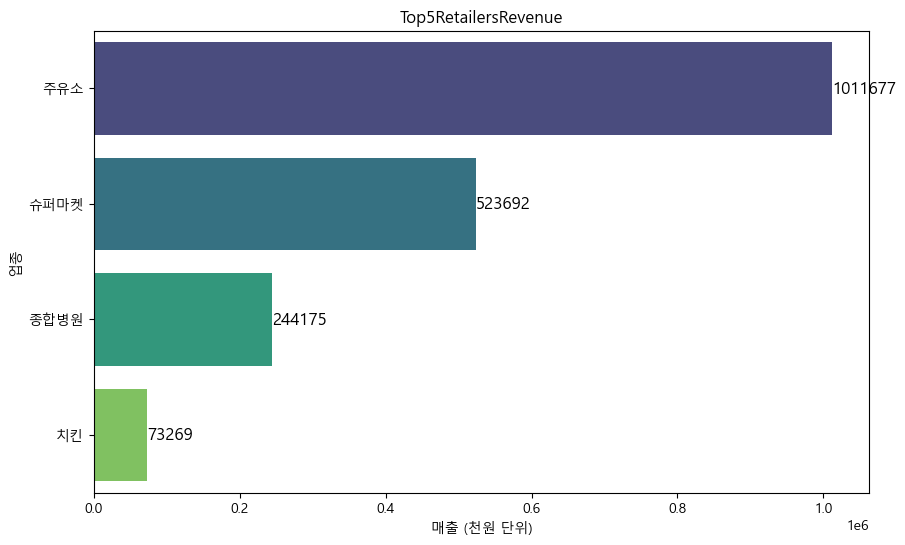

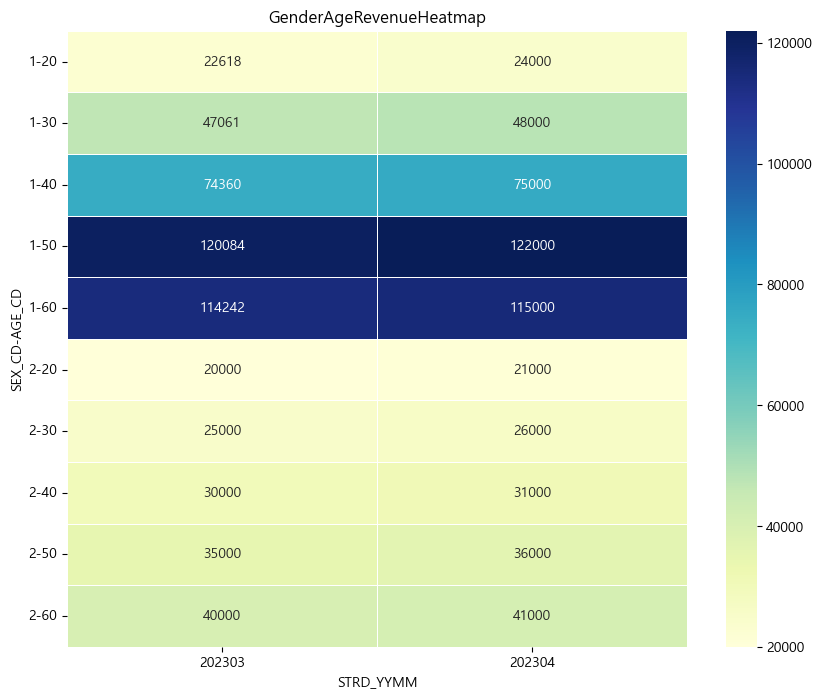

<string>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



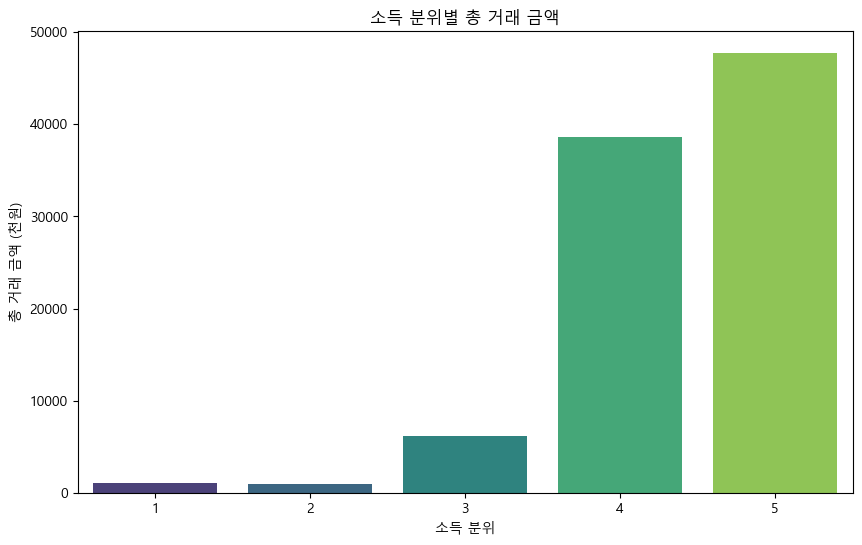

In [40]:
from langchain_experimental.tools import PythonREPLTool

python_repl_tool = PythonREPLTool()

for chart in report_chart_result['charts']:
    generated_sql_query = sql_generate_chain.invoke({"question": chart['chart_generate_prompt']})
    sql_result = execute_query.invoke({"query": generated_sql_query})
    chart_code = chart_code_generate_chain.invoke({"chart_generate_prompt": chart['chart_generate_prompt'], "chart_name": chart['chart_name'], "sql": generated_sql_query, "data": execute_query.invoke({"query": generated_sql_query})})

    python_repl_tool.invoke(chart_code)
